# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [15]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st


# Impor the OpenWeatherMap API key
from api_keys import weather_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

In [16]:
#POINT_COUNT = 1500
POINT_COUNT = 50

# Set the API base URL
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"

HTTP_STATUS_NOT_FOUND = 404

HTTP_STATUS_OK = 200

### Generate the Cities List by Using the `citipy` Library

In [17]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=POINT_COUNT)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=POINT_COUNT)
lat_lngs = zip(lats, lngs)


In [18]:
# Empty list for holding the cities names
cities = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 42


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [19]:
#define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0
        # Log the url, record, and set numbers
        print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Create endpoint URL with each city
    city_url = f"{BASE_URL}?appid={weather_api_key}&units=metric&q={city.replace(' ', '+')}"
    
    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities
    response = requests.get(city_url)
    if response.status_code == HTTP_STATUS_NOT_FOUND:
        print("City not found. Skipping...")
    elif response.status_code == HTTP_STATUS_OK:
        try: 
            # Parse the JSON 
            city_weather = response.json()
            # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
            city_lat = city_weather['coord']['lat']
            city_lng = city_weather['coord']['lon']
            city_max_temp = city_weather['main']['temp_max']
            city_humidity = city_weather['main']['humidity']
            city_clouds = city_weather['clouds']['all']
            city_wind = city_weather['wind']['speed']
            city_country = city_weather['sys']['country']
            city_date = city_weather['dt']

             # Append the City information into city_data list
            city_data.append({"City": city, 
                               "Lat": city_lat, 
                               "Lng": city_lng, 
                               "Max Temp": city_max_temp,
                               "Humidity": city_humidity,
                               "Cloudiness": city_clouds,
                               "Wind Speed": city_wind,
                               "Country": city_country,
                               "Date": city_date,
                              })
            

    # If an error is experienced, skip the city
        except KeyError as e:
            raise e
    else: 
        raise ValueError(f"Unknown Status Code: {response.status_code} for city {city}")
        
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
City not found. Skipping...
-----------------------------
Data Retrieval Complete      
-----------------------------


In [20]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Convert the date
city_data_df['Date'] = pd.to_datetime(city_data_df['Date'], unit='s').dt.date

# Show Record Count
city_data_df.count()

City          41
Lat           41
Lng           41
Max Temp      41
Humidity      41
Cloudiness    41
Wind Speed    41
Country       41
Date          41
dtype: int64

In [21]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,port-aux-francais,-49.3500,70.2167,2.18,84,100,9.76,TF,2023-06-06
1,whitehorse,60.7161,-135.0538,8.78,81,100,3.60,CA,2023-06-06
2,waitangi,-43.9535,-176.5597,9.90,95,100,0.45,NZ,2023-06-06
3,ribeira grande,38.5167,-28.7000,20.22,64,40,8.05,PT,2023-06-06
4,papatowai,-46.5619,169.4708,4.71,86,46,1.92,NZ,2023-06-06


In [22]:
# Export the City_Data into a csv
city_data_df.to_csv("output_data/cities.csv", index_label="City_ID")

In [23]:
# Read saved data
city_data_df = pd.read_csv("output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,port-aux-francais,-49.3500,70.2167,2.18,84,100,9.76,TF,2023-06-06
1,whitehorse,60.7161,-135.0538,8.78,81,100,3.60,CA,2023-06-06
2,waitangi,-43.9535,-176.5597,9.90,95,100,0.45,NZ,2023-06-06
3,ribeira grande,38.5167,-28.7000,20.22,64,40,8.05,PT,2023-06-06
4,papatowai,-46.5619,169.4708,4.71,86,46,1.92,NZ,2023-06-06


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

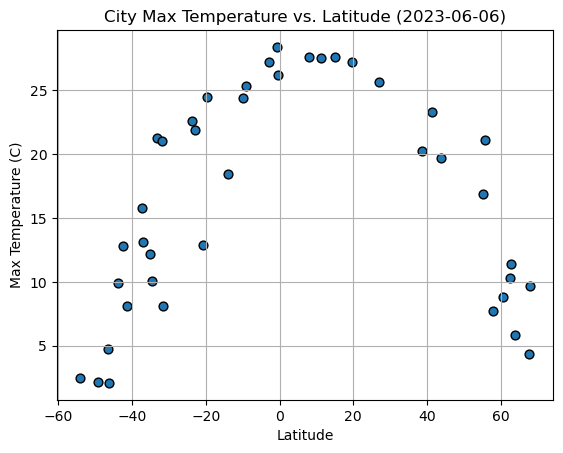

<Figure size 640x480 with 0 Axes>

In [24]:
# Build scatter plot for latitude vs. temperature

date = city_data_df['Date'].max()

city_data_df.plot(kind="scatter", x="Lat", y="Max Temp", xlabel="Latitude",ylabel="Max Temperature (C)",
                  grid=True, edgecolor="black", s=40, title=(f"City Max Temperature vs. Latitude ({date})"))

plt.show()

# Save the figure
plt.savefig("output_data/Fig1.png")



#### Latitude Vs. Humidity

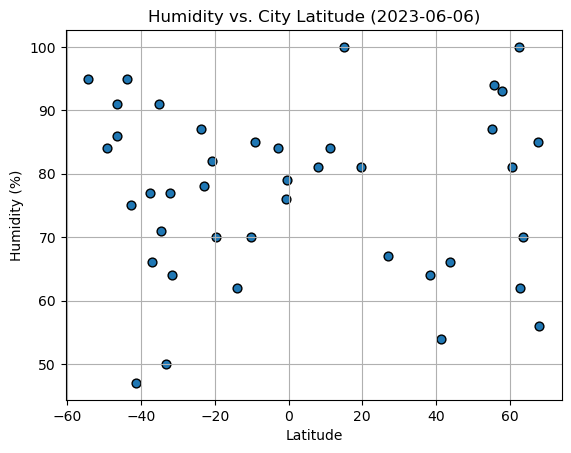

In [25]:
# Build the scatter plots for latitude vs. humidity

city_data_df.plot(kind="scatter", x="Lat", y="Humidity", xlabel="Latitude",ylabel="Humidity (%)",
                  grid=True, edgecolor="black", s=40, title=(f"Humidity vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig2.png")

#show plot
plt.show()


#### Latitude Vs. Cloudiness

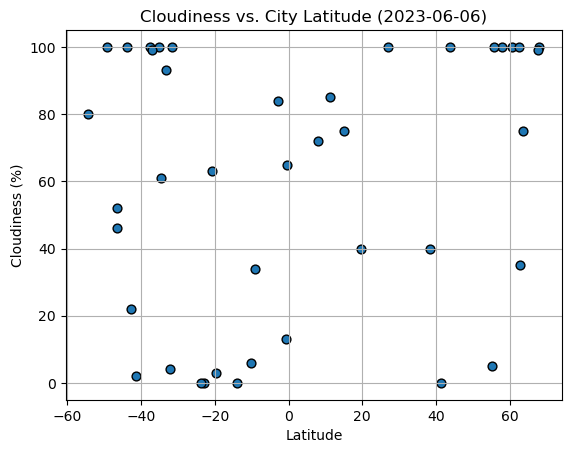

In [26]:
# Build the scatter plots for latitude vs. cloudiness

city_data_df.plot(kind="scatter", x="Lat", y="Cloudiness", xlabel="Latitude",ylabel="Cloudiness (%)",
                  grid=True, edgecolor="black", s=40, title=(f"Cloudiness vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

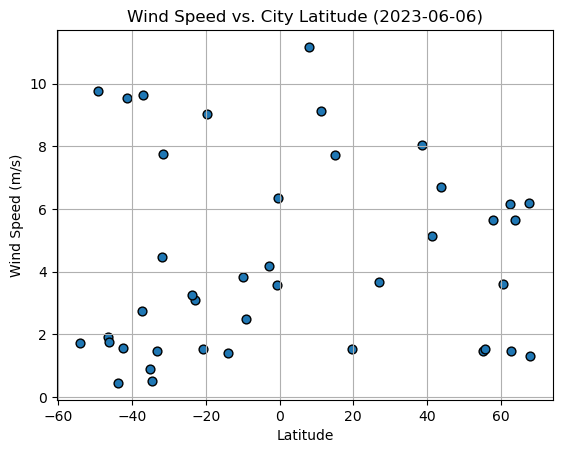

In [27]:
# Build the scatter plots for latitude vs. wind speed

city_data_df.plot(kind="scatter", x="Lat", y="Wind Speed", xlabel="Latitude",ylabel="Wind Speed (m/s)",
                  grid=True, edgecolor="black", s=40, title=(f"Wind Speed vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


In [28]:
# Define a function to create Linear Regression plots
def lin_regress_plot(df, xcol, ycol, x_label, y_label, title):
    df.plot(kind="scatter", x=xcol, y=ycol, xlabel=x_label, ylabel=y_label,
                  grid=True, edgecolor="black", s=40, title=title)
    (slope, intercept, rvalue, pvalue, _) = st.linregress(df[xcol], df[ycol])
    y_calc = df[xcol] * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    plt.plot(df[xcol], y_calc, color="red")
    x_pos = df[xcol].min() + (df[xcol].max() - df[xcol].min()) * 0.1
    y_pos = df[ycol].min() + (df[ycol].max() - df[ycol].min()) * 0.9
    plt.annotate(line_eq, (x_pos, y_pos), fontsize=15, color="red")
    print(f"The r-value is: {rvalue}")
    plt.show()


In [29]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)

northern_hemi_df = city_data_df[city_data_df['Lat']>=0]

# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
1,whitehorse,60.7161,-135.0538,8.78,81,100,3.60,CA,2023-06-06
3,ribeira grande,38.5167,-28.7000,20.22,64,40,8.05,PT,2023-06-06
5,kodiak,57.7900,-152.4072,7.73,93,100,5.66,US,2023-06-06
6,saipan,15.1355,145.7010,27.58,100,75,7.72,MP,2023-06-06
11,bilibino,68.0546,166.4372,9.70,56,100,1.32,RU,2023-06-06


In [30]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df['Lat']<0]

# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,port-aux-francais,-49.3500,70.2167,2.18,84,100,9.76,TF,2023-06-06
2,waitangi,-43.9535,-176.5597,9.90,95,100,0.45,NZ,2023-06-06
4,papatowai,-46.5619,169.4708,4.71,86,46,1.92,NZ,2023-06-06
7,port mathurin,-19.6833,63.4167,24.49,70,3,9.02,MU,2023-06-06
8,huarmey,-10.0681,-78.1522,24.41,70,6,3.82,PE,2023-06-06


###  Temperature vs. Latitude Linear Regression Plot

The r-value is: -0.9135722825405479


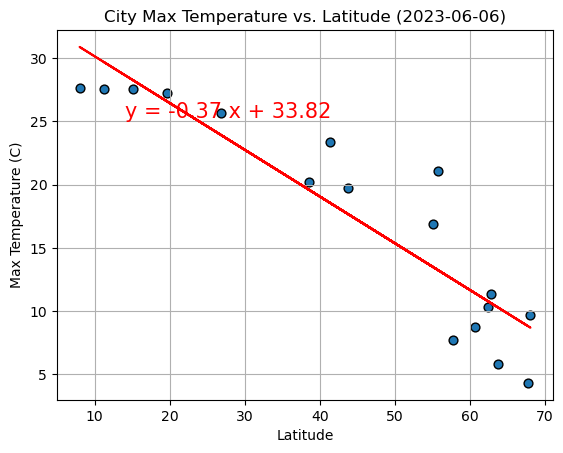

In [31]:
# Linear regression on Northern Hemisphere

lin_regress_plot(df=northern_hemi_df, xcol="Lat", ycol="Max Temp", x_label="Latitude", 
                 y_label="Max Temperature (C)", title=(f"City Max Temperature vs. Latitude ({date})"))

The r-value is: 0.8838025564655848


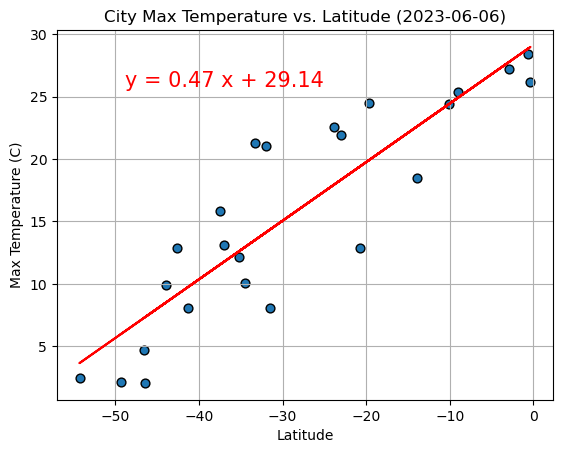

In [32]:
# Linear regression on Southern Hemisphere

lin_regress_plot(df=southern_hemi_df, xcol="Lat", ycol="Max Temp", x_label="Latitude", 
                 y_label="Max Temperature (C)", title=(f"City Max Temperature vs. Latitude ({date})"))

**Discussion about the linear relationship:** The correlation between latitude and maximum temperature is very strong across both the Northern and Southern Hemispheres. The closer the latitude is to 0, the higher the maximum temperature. The further it gets from 0 in either direction, the lower the maximum temperature. This shows us that cities located closest to the equator will be the hottest cities in the world. 

### Humidity vs. Latitude Linear Regression Plot

The r-value is: -0.11126318111485767


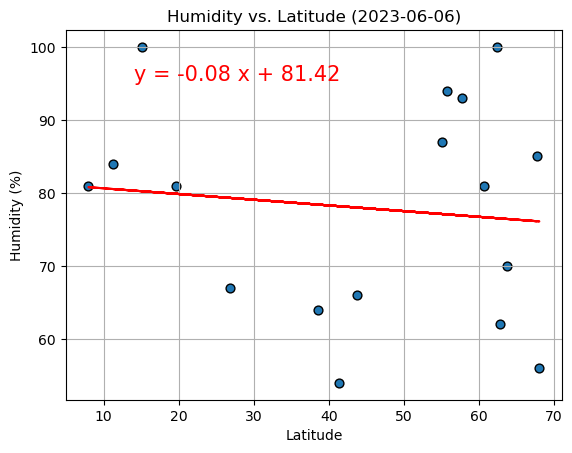

In [33]:
# Northern Hemisphere

lin_regress_plot(df=northern_hemi_df, xcol="Lat", ycol="Humidity", x_label="Latitude", 
                 y_label="Humidity (%)", title=(f"Humidity vs. Latitude ({date})"))



The r-value is: -0.13585815510379193


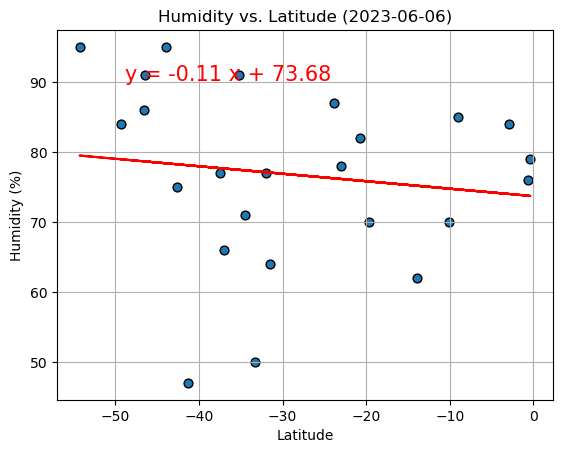

In [34]:
# Southern Hemisphere
lin_regress_plot(df=southern_hemi_df, xcol="Lat", ycol="Humidity", x_label="Latitude", 
                 y_label="Humidity (%)", title=(f"Humidity vs. Latitude ({date})"))


**Discussion about the linear relationship:** The correlation between latitude and humidity is very weak across both hemispheres. Proximity to equator has little to do with the humidity levels in a given city. Humidity is more closely related to other external factors, for instance proximity to large/warm bodies of water. 

### Cloudiness vs. Latitude Linear Regression Plot

The r-value is: 0.15132439602010042


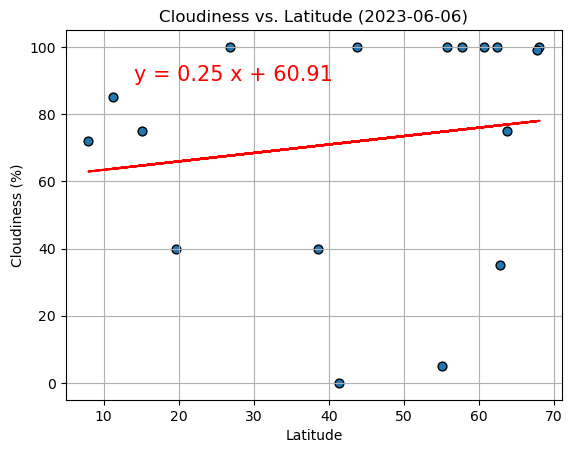

In [35]:
# Northern Hemisphere

lin_regress_plot(df=northern_hemi_df, xcol="Lat", ycol="Cloudiness", x_label="Latitude", 
                 y_label="Cloudiness (%)", title=(f"Cloudiness vs. Latitude ({date})"))



The r-value is: -0.04966327529842648


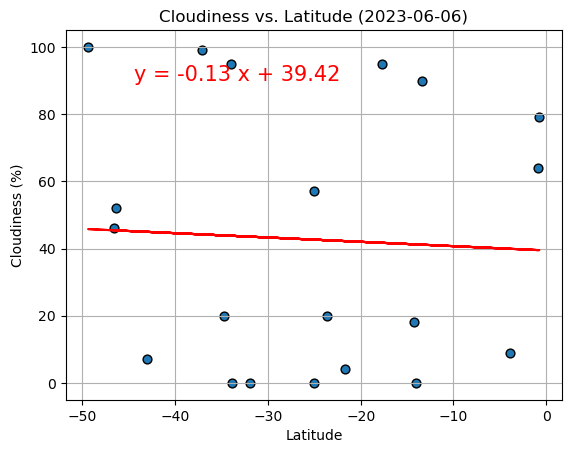

In [169]:
# Southern Hemisphere

lin_regress_plot(df=southern_hemi_df, xcol="Lat", ycol="Cloudiness", x_label="Latitude", 
                 y_label="Cloudiness (%)", title=(f"Cloudiness vs. Latitude ({date})"))


**Discussion about the linear relationship:** The correlation between latitude and cloudiness is weak across both hemispheres. Proximity to equator has little to do with the cloudiness levels in a given city. If we wish to learn more about wind speed, we will have to examine other external factors. 

### Wind Speed vs. Latitude Linear Regression Plot

The r-value is: 0.06792451095746141


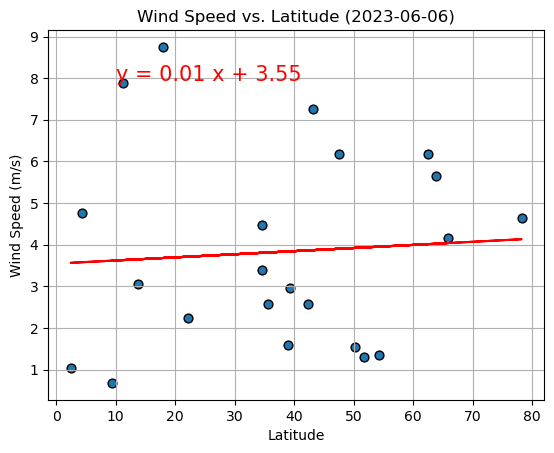

In [170]:
# Northern Hemisphere

lin_regress_plot(df=northern_hemi_df, xcol="Lat", ycol="Wind Speed", x_label="Latitude", 
                 y_label="Wind Speed (m/s)", title=(f"Wind Speed vs. Latitude ({date})"))




The r-value is: -0.23144428052941152


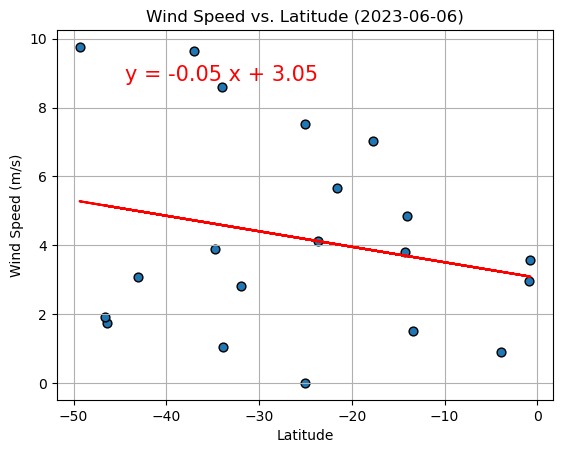

In [171]:
# Southern Hemisphere
lin_regress_plot(df=southern_hemi_df, xcol="Lat", ycol="Wind Speed", x_label="Latitude", 
                 y_label="Wind Speed (m/s)", title=(f"Wind Speed vs. Latitude ({date})"))



**Discussion about the linear relationship:** The correlation between wind speed and latitude is weak across both hemispheres. Proximity to equator has little to do with the wind speeds of a given city. If we wish to learn more about wind speed, we will have to examine other external factors. 